In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import traintools
from trainconstants import *

sns.set()
%matplotlib inline

df = pd.read_csv("datasets/nsdata1.txt",  delimiter=r"\s+")
df.head(10)

,train_number,from,to,departure_time,arrival_time,first_class,second_class
0,2123,2,3,700,740,4,58
1,2123,3,4,743,838,14,328
2,2127,1,2,648,755,47,340
3,2127,2,3,801,841,35,272
4,2127,3,4,843,938,19,181
5,2131,1,2,755,858,100,616
6,2131,2,3,902,941,52,396
7,2131,3,4,943,1038,27,270
8,2135,1,2,856,958,61,407
9,2135,2,3,1003,1043,41,364


In [2]:
df['departure_time'] = df['departure_time'].map(traintools.to_minutes_past_midnight)
df['arrival_time'] = df['arrival_time'].map(traintools.to_minutes_past_midnight)

In [3]:
minimum_number_of_type_3_trains = traintools.minimum_number_of_trains_at_time_t(df, TYPE_3_TRAIN)
minimum_number_of_type_4_trains = traintools.minimum_number_of_trains_at_time_t(df, TYPE_4_TRAIN)
minimum_number_of_type_3_compartments = traintools.minimum_number_of_trains_at_time_t(df, COMPARTMENT_BASED_ON_3)
minimum_number_of_type_4_compartments = traintools.minimum_number_of_trains_at_time_t(df, COMPARTMENT_BASED_ON_4)

type 3 trains: number of trains    22.0
dtype: float64
type 4 trains: number of trains    17.0
dtype: float64
type 3 compartments: number of trains    62.0
dtype: float64
type 4 compartments: number of trains    62.0
dtype: float64


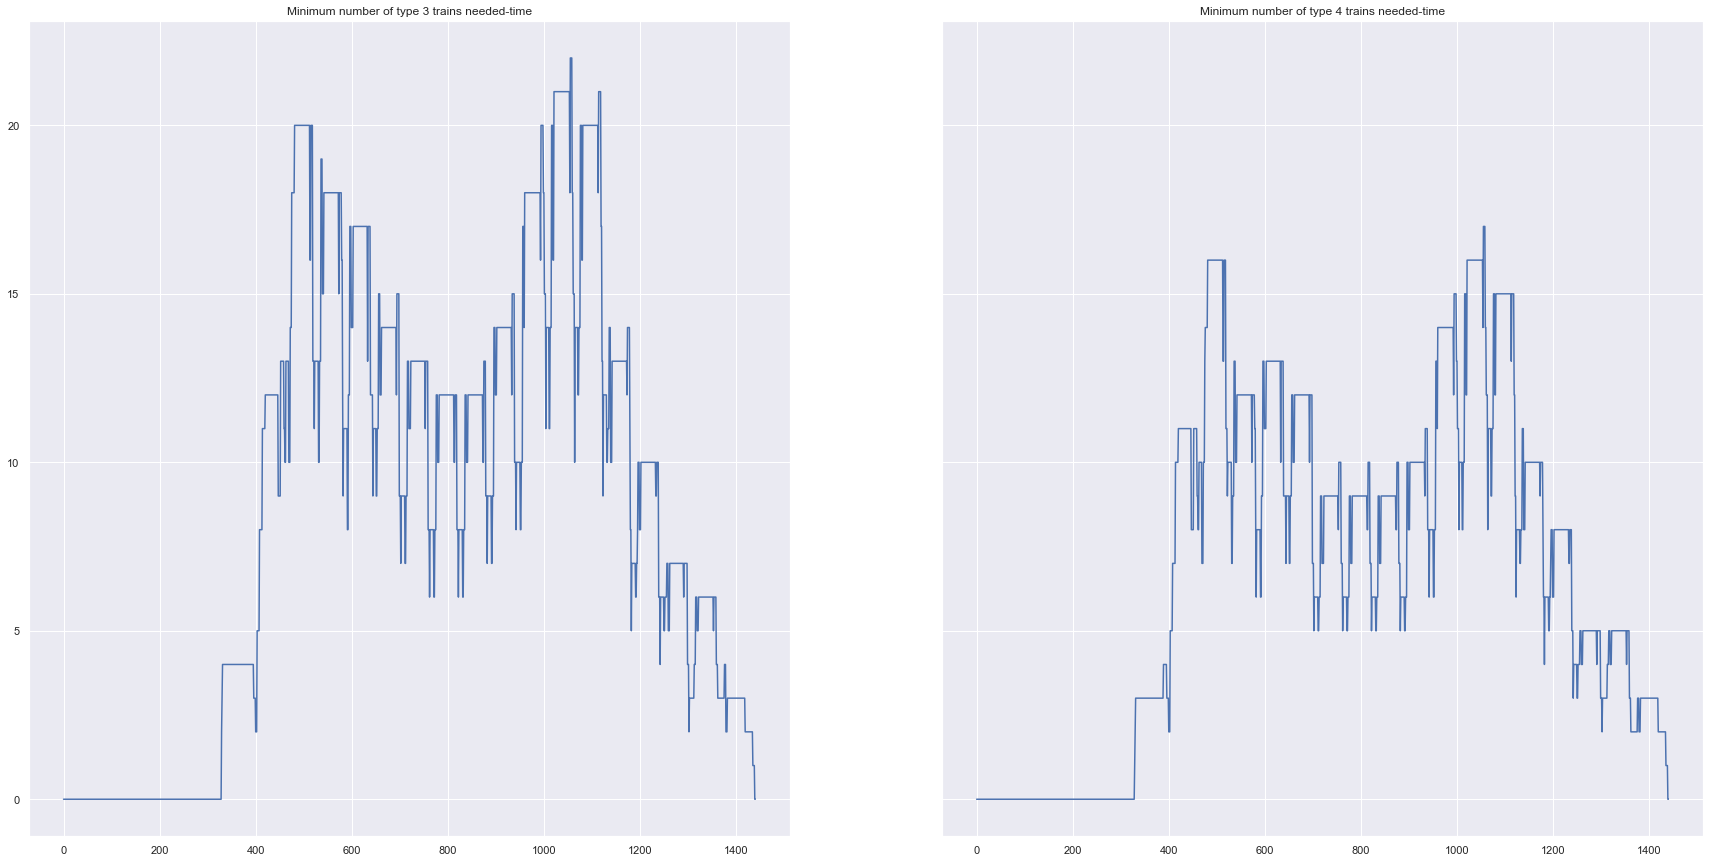

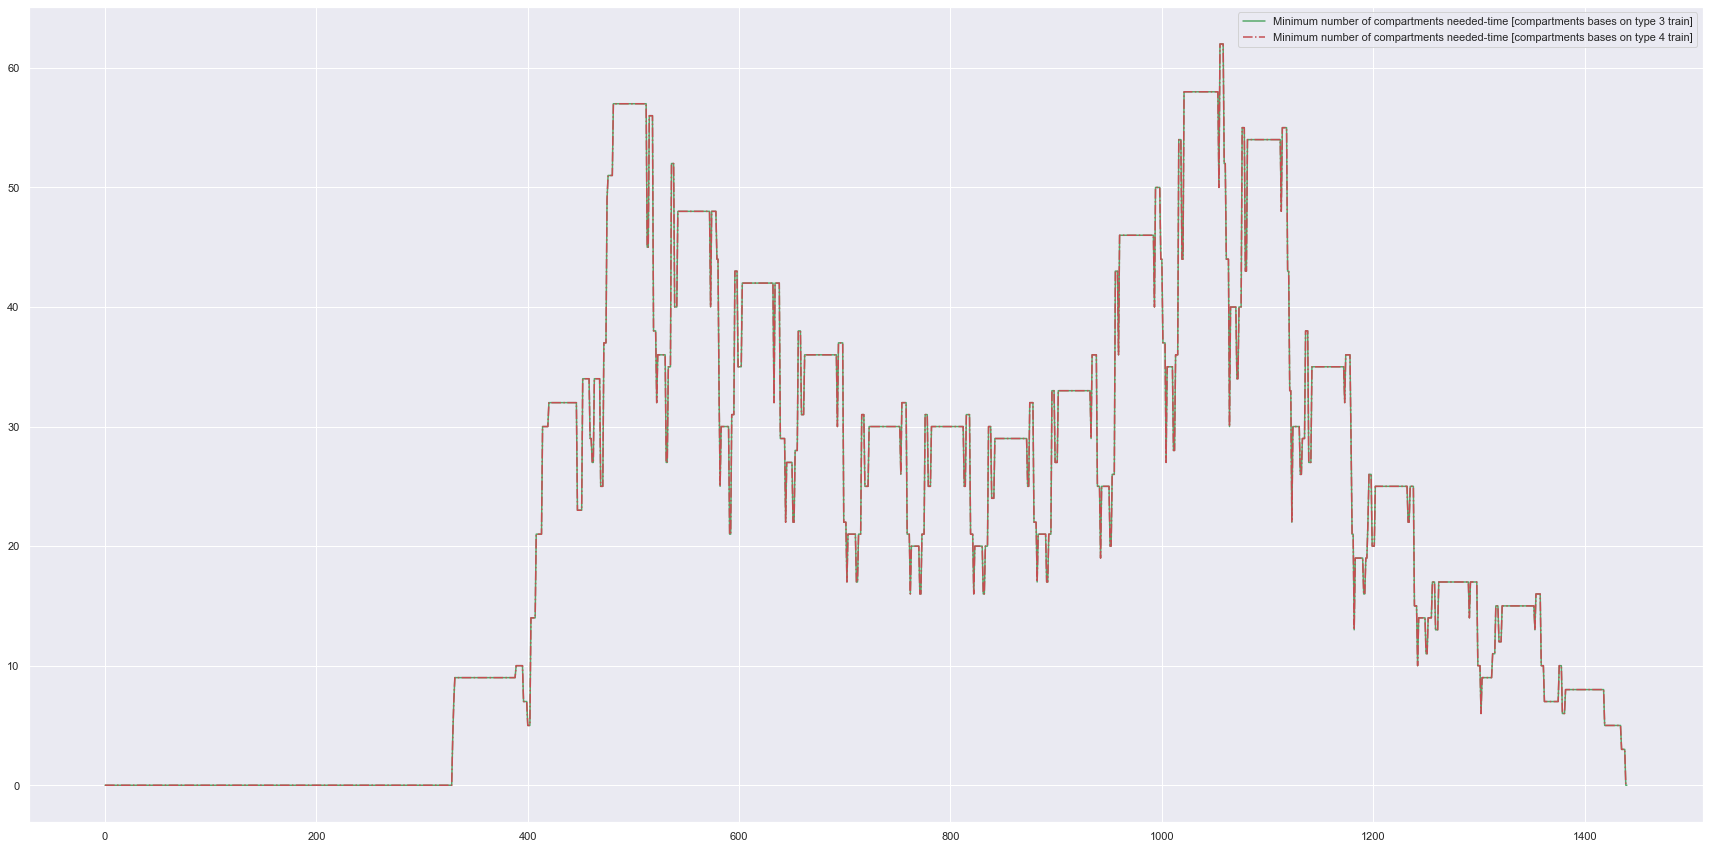

In [15]:
fig1, ax1 = plt.subplots(nrows=1, ncols=2, squeeze=False, sharex=True, sharey=True, figsize=(30, 15))
fig2, ax2 = plt.subplots(nrows=1, ncols=1, squeeze=False, figsize=(30, 15))

minimum_number_of_type_3_trains.plot(ax=ax1[0, 0])
minimum_number_of_type_4_trains.plot(ax=ax1[0, 1])
minimum_number_of_type_3_compartments.plot(color='g', ax=ax2[0, 0])
minimum_number_of_type_4_compartments.plot(color='r', linestyle='-.', ax=ax2[0, 0])

ax1[0, 0].set_title('Minimum number of type 3 trains needed-time')
ax1[0, 1].set_title('Minimum number of type 4 trains needed-time')
ax1[0, 0].legend().remove()
ax1[0, 1].legend().remove()
ax2[0, 0].legend([
    'Minimum number of compartments needed-time [compartments bases on type 3 train]', 
    'Minimum number of compartments needed-time [compartments bases on type 4 train]'
    ])

print(f'type 3 trains: {minimum_number_of_type_3_trains.max()}')
print(f'type 4 trains: {minimum_number_of_type_4_trains.max()}')
print(f'type 3 compartments: {minimum_number_of_type_3_compartments.max()}')
print(f'type 4 compartments: {minimum_number_of_type_4_compartments.max()}')

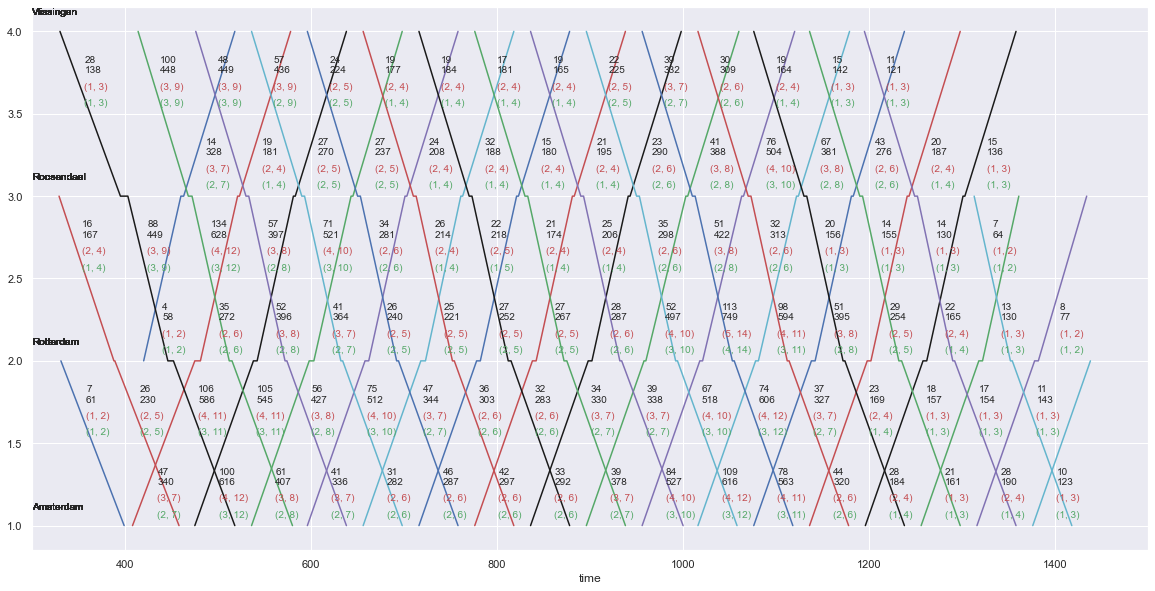

In [5]:
trains = traintools.create_trains_dict(df)

# trains_subset = dict(itertools.islice(trains.items(), 10)) # subset of the first 10 trains

viz = traintools.VisualizeSchedule(trains)
viz.visualize()